In [1]:
import numpy as np
import scipy.io.wavfile, scipy.signal
from matplotlib import pyplot as plt
import time

In [2]:
class Song:
    name = "name"
    bpm = 120,
    filepath = "test"

    def __init__(self, name, bpm, filepath):
        self.name = name
        self.bpm = bpm
        self.filepath = filepath
         

In [3]:
bandLimits = [0, 200, 400, 800, 1600, 3200, 6400]    
combFilterPulses = 9 # one pulse <=> one second
minBpm = 60
maxBpm = 240

resampleSignal = True
resampleRatio = 4

drawPlots = True
drawFftPlots = True
drawCombFilterPlots = True
drawSongBpmEnergyPlot = True

useConvolveMethod = False

startTime = time.time()

song = Song("Dave_Brubeck_Quartet_Take_Five", 140, "songs\\jazz\\Dave_Brubeck_Quartet_Take_Five.wav")

In [4]:
def prepare_plot_dictionary(minBpm, maxBpm):
    dictionary = {}
    for bpm in range(minBpm, maxBpm):
        dictionary[bpm] = 0
    return dictionary

In [5]:
def draw_plot(is_draw_plots:bool, yData, title, xAxis, yAxis, xData = 0):
    if is_draw_plots:
        if xData is 0:
            plt.plot(yData)
        else:
            plt.plot(yData, xData)
        plt.title(title)
        plt.xlabel(xAxis)
        plt.ylabel(yAxis)
        plt.show() 
        

In [6]:
def draw_fft_plot(drawPlots:bool, yData, plotTitle, samplingFrequency:int):
    if drawPlots:
        length = len(yData)
        h = abs(yData/length)
        h = h[1:int(length/2+1)]
        f = samplingFrequency * ((np.arange(0,int(length/2)))/length)
        
        plt.plot(f, h)
        plt.title(plotTitle)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, 5000)
        plt.show()   

In [7]:
def draw_comb_filter_fft_plot(is_draw_plots:bool, yData, plotTitle, samplingFrequency:int):
    if is_draw_plots:
        length = len(yData)
        h = abs(yData/length)
        h = h[1:int(length/2+1)]
        f = samplingFrequency* ((np.arange(0,int(length/2)))/length)
        
        plt.plot(f, h)
        plt.title(plotTitle)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, 10)
        plt.show() 

In [8]:
def center_sample_to_beat(signal, seconds):
    n = len(signal)
    index = 0

    max = np.max(abs(signal))

    for i in range(0, n):
        if abs(signal[i]) > max*0.9:
            index = i
            break

    lastindex = seconds
    lastindex += index
    if lastindex > n:
        lastindex = n
    return signal[index:int(lastindex)]

In [9]:
def filterbank(signal, bandlimits, samplingFrequency):
    dft = np.fft.fft(signal)
    n = len(dft)
    nbands = len(bandlimits)
    bl = np.zeros(nbands, int)
    br = np.zeros(nbands, int)

    #   % Bring band scale from Hz to the points in our vectors
    for band in range(0, nbands - 1):
        bl[band] = np.floor(bandlimits[band] / samplingFrequency * n / 2) + 1
        br[band] = np.floor(bandlimits[band + 1] / samplingFrequency * n / 2)

    bl[0] = 0
    bl[nbands - 1] = np.floor(bandlimits[nbands - 1] / samplingFrequency * n / 2) + 1
    br[nbands - 1] = np.floor(n / 2)

    output = np.zeros([nbands, n], dtype=complex)

    # Create the frequency bands and put them in the vector output.
    for band in range(0, nbands):
        for hz in range(bl[band], br[band]):
            output[band, hz] = dft[hz]
        for hz in range(n - br[band], n - bl[band]):
            output[band, hz] = dft[hz]

    output[1, 1] = 0
    return output

In [10]:
def read_song(filename):
    sample_freq, data = scipy.io.wavfile.read(filename)
    signal = np.frombuffer(data, np.int16)
    return signal, sample_freq

In [11]:
def hann(signal, winLength, bandslimits, samplingFrequency):
    n = len(signal[0])
    nbands = len(bandslimits)
    hannlen = winLength * 2 * samplingFrequency
    hann = np.zeros(n)
    wave = np.zeros([nbands, n], dtype=complex)
    output = np.zeros([nbands, n], dtype=complex)
    freq = np.zeros([nbands, n], dtype=complex)
    filtered = np.zeros([nbands, n], dtype=complex)

    # Create half-Hanning window.
    for a in range(1, int(hannlen)):
        hann[a] = (np.cos(a * np.pi / hannlen / 2)) ** 2

    # Take IFFT to transfrom to time domain.
    for band in range(0, nbands):
        wave[band] = np.real(np.fft.ifft(signal[band]))

    # Full - wave rectification in the time domain. And back to frequency with FFT.
    for band in range(0, nbands):
        for j in range(0, n):
            if wave[band, j] < 0:
                wave[band, j] = -wave[band, j]
        freq[band] = np.fft.fft(wave[band])

    # Convolving with half - Hanning same as multiplying in frequency.Multiply half - Hanning
    # FFT by signal FFT.Inverse transform to get output in the time domain.
    for band in range(0, nbands):
        filtered[band] = freq[band] * np.fft.fft(hann)
        output[band] = np.real(np.fft.ifft(filtered[band]))

    return output

In [12]:
def diffrect(signal, nbands=6):
    n = len(signal[0])
    output = np.zeros([nbands, n], dtype=complex)

    for band in range(0, nbands):
        for j in range(5, n):
            d = signal[band, j] - signal[band, j-1]
            if d > 0:
                output[band, j] = d;

    return output

In [13]:
def bpm_comb_filter(signal, accuracy:int, minBpm:int, maxBpm:int, bandsLimits, samplingFrequency, combFilterPulses, plotDictionary):
    n = len(signal[0])
    bands_amount = len(bandsLimits)
    dft = np.zeros([bands_amount, n], dtype=complex)

    if minBpm < 60:
        minBpm = 60

    if maxBpm > 240:
        maxBpm = 240

    # Get signal in frequency domain
    for band in range(0, bands_amount):
        dft[band] = np.fft.fft(signal[band])
        draw_fft_plot(drawFftPlots, dft[band], f"Band[{band}] DFT", samplingFrequency)

    # % Initialize max energy to zero
    maxEnergy = 0
    for bpm in range(minBpm, maxBpm, accuracy):
        # % Initialize energy and filter to zero(s)
        this_bpm_energy = 0
        fil = np.zeros(n)

        # Calculate the difference between peaks in the filter for a certain tempo
        filter_step = np.floor(60 / bpm * samplingFrequency)
        percent_done = 100 * (bpm - minBpm) / (maxBpm - minBpm)
        print(percent_done)


        # Set every filter's step samples of the filter to one
        for a in range(0, combFilterPulses):
            fil[a * int(filter_step) + 1] = 1

        draw_plot(drawCombFilterPlots, fil, f"Timecomb bpm: {bpm}", "Sample/Time", "Amplitude")
        # Get the filter in the frequency domain
        dftfil = np.fft.fft(fil)
        draw_comb_filter_fft_plot(drawFftPlots, dftfil, f"Filter's signal DFT {bpm}", samplingFrequency)

        for band in range(0, bands_amount):
            x = (abs(dftfil * dft[band])) ** 2
            this_bpm_energy = this_bpm_energy + sum(x)

        plotDictionary[bpm] = this_bpm_energy
        # If greater than all previous energies, set current bpm to the bpm of the signal
        if this_bpm_energy > maxEnergy:
            songBpm = bpm
            maxEnergy = this_bpm_energy

    return songBpm

In [14]:
def bpm_comb_filter_convolve(signal, accuracy, minBpm, maxBpm, bandlimits, maxFreq, plot_dictionary):
    n = len(signal[0])
    nbands = len(bandlimits)
    dft = np.zeros([nbands, n], dtype=complex)

    if minBpm < 60:
        minBpm = 60

    if maxBpm > 240:
        maxBpm = 240

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = np.fft.fft(signal[band])
        draw_fft_plot(drawFftPlots, dft[band], f"Band[{band}] DFT", maxFreq)

    # % Initialize max energy to zero
    maxe = 0
    for bpm in range(minBpm, maxBpm, accuracy):
        # % Initialize energy and filter to zero(s)
        e = 0

        # Calculate the difference between peaks in the filter for a certain tempo
        filterLength = 2
        nstep = np.floor(60 / bpm * maxFreq)
        percent_done = 100 * (bpm - minBpm) / (maxBpm - minBpm)
        fil = np.zeros(int(filterLength * nstep))

        print(percent_done)

        # Set every nstep samples of the filter to one
        for a in range(0, filterLength):
            fil[a * int(nstep)] = 1

        draw_plot(drawCombFilterPlots, fil, f"Timecomb bpm: {bpm}", "Sample/Time", "Amplitude")

        # Get the filter in the frequency domain
        dftfil = np.fft.fft(fil)
        # dftfil = scipy.signal.resample(dftfil, len(dft[0]))

        draw_comb_filter_fft_plot(drawCombFilterPlots, dftfil, f"Filter DFT {bpm}", maxFreq)
        for band in range(0, nbands-1):
            filt = scipy.convolve(signal[band], fil)
            f_filt = abs(np.fft.fft(filt))
            draw_fft_plot(drawFftPlots, f_filt, f"Convolve DFT {bpm}", maxFreq)

            x = abs(f_filt)**2
            e = e + sum(x)


        plot_dictionary[bpm] = e
        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            sbpm = bpm
            maxe = e

    return sbpm

In [15]:
def detectMetre(signal, tempo:int, bandlimits, maxFreq, npulses):
    length = len(signal[0])
    print(length)
    n = int(npulses * maxFreq * (60/tempo))
    print(n)
    nbands = len(bandlimits)
    dft = np.zeros([nbands, n], dtype=complex)

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = np.fft.fft(signal[band, 0:n])
        draw_plot(drawPlots, signal[band], f"Signal[{band}]", "Sample/Time", "Amplitude")
        draw_fft_plot(drawFftPlots, dft[band], f"Signal[{band}] dft", maxFreq)
        draw_comb_filter_fft_plot(drawFftPlots, dft[band], f"Signal[{band}] dft", maxFreq)

    metres = {}
    metre, metre_dft = four_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = three_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = five_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    # % Initialize max energy to zero
    maxe = 0
    for metrum in metres:
        # % Initialize energy and filter to zero(s)
        e = 0

        for band in range(0, nbands):
            x = (abs(metres[metrum] * dft[band])) ** 2
            e = e + sum(x)

        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            song_metre = metrum
            maxe = e

    return song_metre


def four_forth(tempo, n, sampling_frequency, npulses):
    fil = np.zeros(n)
    nstep = np.floor(60 / tempo * sampling_frequency)
    index = 0
    bit = 0
    while index < n and bit <= npulses:
        value = 2
        if bit % 2 > 0:
            value = 1

        fil[int(index)] = value
        index += nstep
        bit += 1

    draw_plot(drawCombFilterPlots, fil, "4/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 4/4 filter dft", sampling_frequency)
    energy = sum(abs(dft) ** 2)
    print("filter 4/4 energy: ", energy)
    dft = dft / energy
    energy = sum(abs(dft) ** 2)
    print("normalized filter 4/4 energy: ", energy)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 4/4 filter normalized dft", sampling_frequency)
    return "4/4", dft


def three_forth(song_tempo:int, n:int, sampling_frequency:int, filter_pulses:int):
    fil = np.zeros(n)
    nstep = np.floor(60 / song_tempo * sampling_frequency)  # every third bit
    index = 0
    bit = 0
    while index < n and bit <= filter_pulses:
        value = 2
        if bit % 3 > 0:
            value = 1
        fil[int(index)] = value
        index += nstep
        bit += 1

    draw_plot(drawCombFilterPlots, fil, "3/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 3/4 filter dft", sampling_frequency)
    energy = sum(abs(dft) ** 2)
    print("filter 3/4 energy: ", energy)
    dft = dft / energy
    energy = sum(abs(dft) ** 2)
    print("normalized filter 3/4 energy: ", energy)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 3/4 filter normalized dft", sampling_frequency)
    return "3/4", dft

def five_forth(song_tempo:int, n:int, sampling_frequency:int, filter_pulses:int):
    fil = np.zeros(n)
    nstep = np.floor(60 / song_tempo * sampling_frequency)  # every third bit
    index = 0
    bits = 0
    bit = 1
    while index < n and bits <= filter_pulses:
        value = 1
        if bit == 2 or bit == 4 or bit == 5:
            value = 2
        fil[int(index)] = value
        index += nstep
        bit += 1
        bits += 1
        if bit > 5:
            bit = 1

    draw_plot(drawCombFilterPlots, fil, "5/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 5/4 filter dft", sampling_frequency)
    energy = sum(abs(dft) ** 2)
    print("filter 5/4 energy: ", energy)
    dft = dft / energy
    energy = sum(abs(dft) ** 2)
    print("normalized filter 5/4 energy: ", energy)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 5/4 filter normalized dft", sampling_frequency)
    return "5/4", dft

In [16]:
def detectMetre_convolve(signal, tempo:int, bandlimits, maxFreq, npulses):
    length = len(signal[0])
    print(length)
    n = int(npulses * maxFreq * (60/tempo))
    print(n)
    nbands = len(bandlimits)
    
    for band in range(0, nbands):
        draw_plot(drawPlots, signal[band], f"band: {band}", "Sample/Time", "Amplitude")

    metres = {}
    metre, metre_dft = four_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = three_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = five_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    # % Initialize max energy to zero
    maxe = 0
    for metrum in metres:
        # % Initialize energy and filter to zero(s)
        e = 0

        for band in range(0, nbands):
            filt = scipy.convolve(signal[band], metres[metrum])
            f_filt = abs(np.fft.fft(filt))
            draw_plot(drawPlots, f_filt, metrum, "Sample/Time", "Amplitude")
            x = abs(f_filt)**2
            e = e + sum(x)

        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            song_metre = metrum
            maxe = e

    return song_metre


def four_forth(song_tempo:int, n:int, sampling_frequency:int, npulses:int):
    fil = np.zeros(int(4 * sampling_frequency * (60/song_tempo)))
    nstep = np.floor(60 / song_tempo * sampling_frequency)
    
    fil[int(0*nstep)] = 1
    fil[int(1*nstep)] = 2
    fil[int(2*nstep)] = 1
    fil[int(3*nstep)] = 2

    draw_plot(drawCombFilterPlots, fil, "4/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 4/4 filter dft", sampling_frequency)
    return "4/4", fil


def three_forth(song_tempo:int, n:int, sampling_frequency:int, filter_pulses:int):
    fil = np.zeros(int(3 * sampling_frequency * (60/song_tempo)))
    nstep = np.floor(60 / song_tempo * sampling_frequency)
    
    fil[int(0*nstep)] = 1
    fil[int(1*nstep)] = 1
    fil[int(2*nstep)] = 2

    draw_plot(drawCombFilterPlots, fil, "3/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 3/4 filter dft", sampling_frequency)
    return "3/4", fil

def five_forth(song_tempo:int, n:int, sampling_frequency:int, filter_pulses:int):
    fil = np.zeros(int(5 * sampling_frequency * (60/song_tempo)))
    nstep = np.floor(60 / song_tempo * sampling_frequency)
    
    fil[int(0*nstep)] = 1
    fil[int(1*nstep)] = 2
    fil[int(2*nstep)] = 1
    fil[int(3*nstep)] = 2
    fil[int(4*nstep)] = 2

    draw_plot(drawCombFilterPlots, fil, "5/4", "Sample/Time", "Amplitude")
    dft = np.fft.fft(fil)
    draw_comb_filter_fft_plot(drawFftPlots, dft, f"Metre 5/4 filter dft", sampling_frequency)
    return "5/4", fil

C:\Users\marek\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


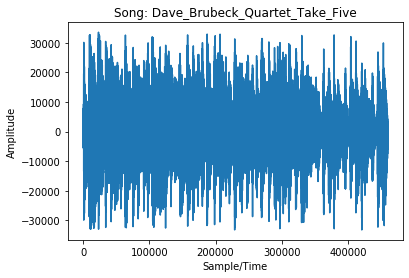

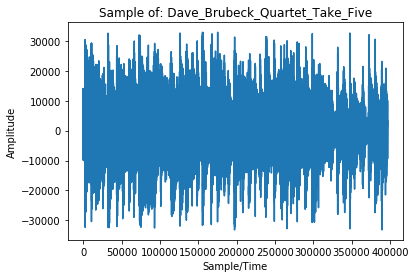

In [17]:
signal, samplingFrequency = read_song(song.filepath)

if(resampleSignal):
    signal = scipy.signal.resample(signal, int(len(signal)/resampleRatio))
    samplingFrequency /= resampleRatio
    
sample_length = combFilterPulses * samplingFrequency
seconds = sample_length * 4
draw_plot(drawPlots, signal, f"Song: {song.name}", "Sample/Time", "Amplitude")
song_length = signal.size

start = int(np.floor(song_length / 2 - seconds / 2))
stop = int(np.floor(song_length / 2 + seconds / 2))
if start < 0:
    start = 0
if stop > song_length:
    stop = song_length

sample = signal[start:stop]
draw_plot(drawPlots, sample, f"Sample of: {song.name}", "Sample/Time", "Amplitude")

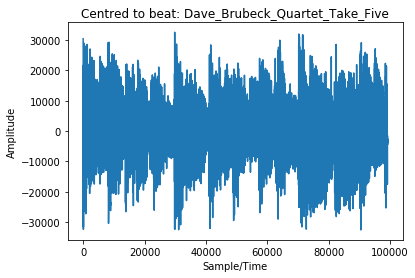

In [18]:
centred = center_sample_to_beat(sample, sample_length)
draw_plot(drawPlots, centred, f"Centred to beat: {song.name}", "Sample/Time", "Amplitude")

Filtering song {song.name}...


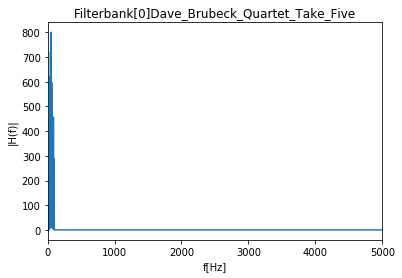

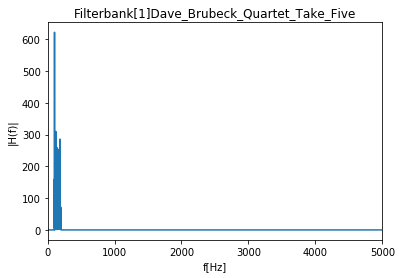

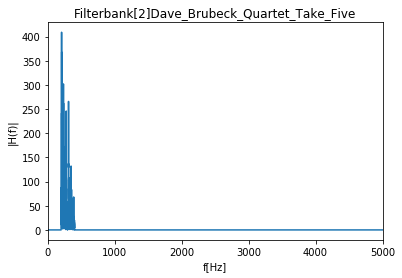

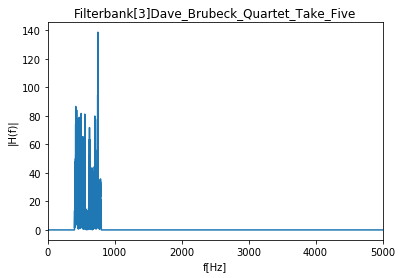

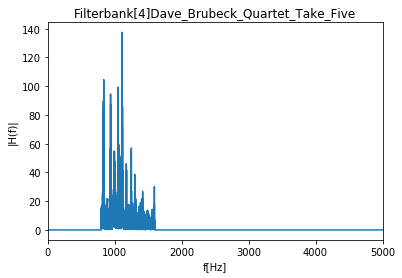

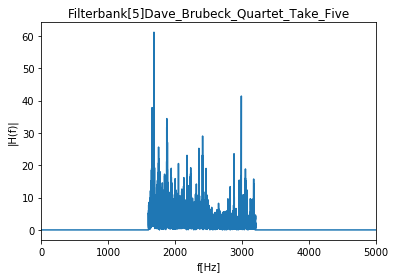

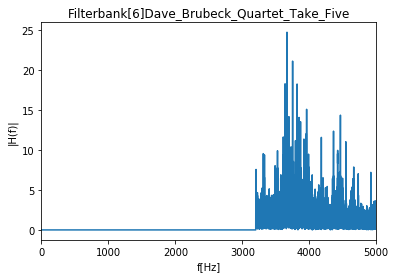

In [19]:
print('Filtering song {song.name}...')
fastFourier = filterbank(centred, bandLimits, samplingFrequency)
for i in range(0, len(bandLimits)):
    draw_fft_plot(drawPlots, fastFourier[i], f"Filterbank[{i}]{song.name}", samplingFrequency)

Windowing song Dave_Brubeck_Quartet_Take_Five...


C:\Users\marek\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


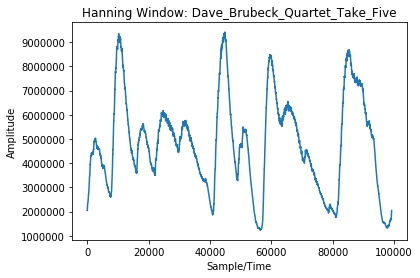

In [20]:
print(f'Windowing song {song.name}...')
hanningWindow = hann(fastFourier, 0.2, bandLimits, samplingFrequency)
draw_plot(drawPlots, hanningWindow[1], f"Hanning Window: {song.name}", "Sample/Time", "Amplitude")

Differentiating song Dave_Brubeck_Quartet_Take_Five...


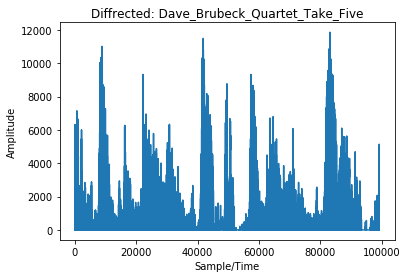

In [21]:
print(f'Differentiating song {song.name}...')
diffrected = diffrect(hanningWindow, len(bandLimits))
draw_plot(drawPlots, diffrected[1], f"Diffrected: {song.name}", "Sample/Time", "Amplitude")

CombFiltering song Dave_Brubeck_Quartet_Take_Five...


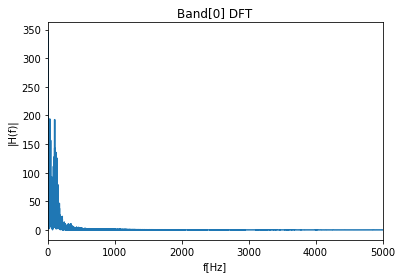

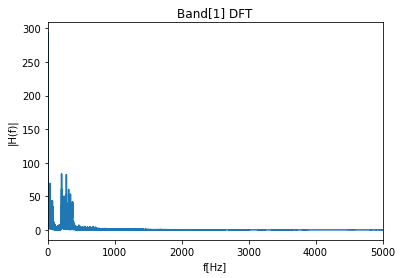

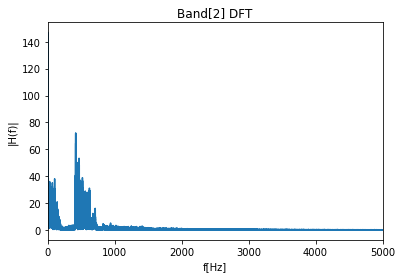

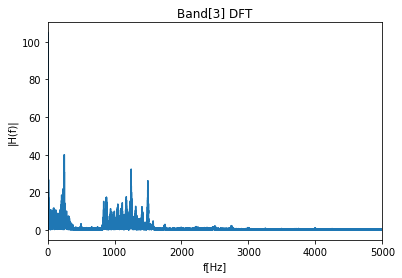

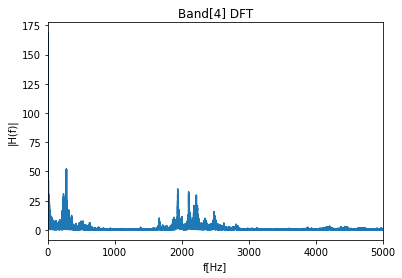

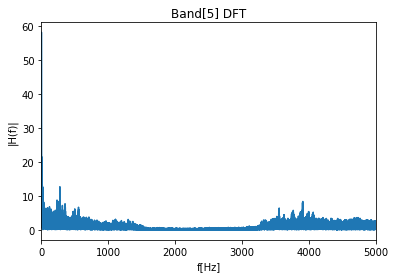

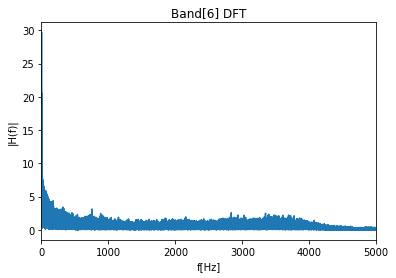

0.0


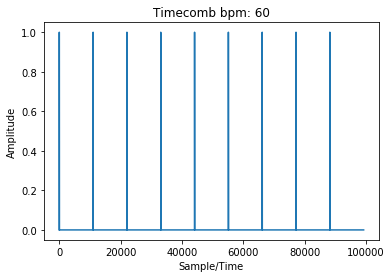

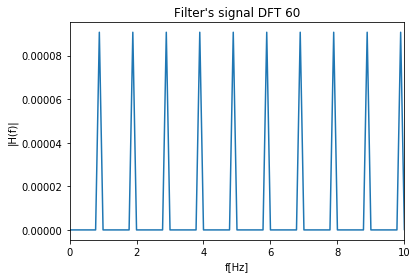

2.7777777777777777


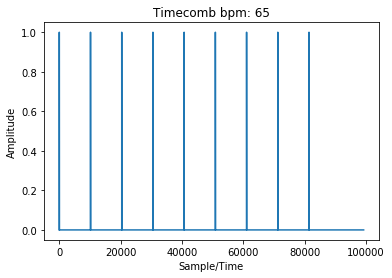

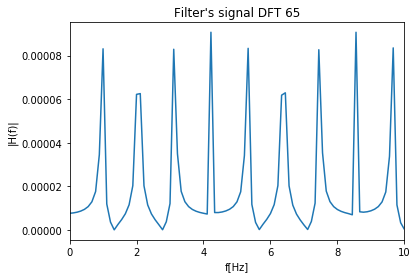

5.555555555555555


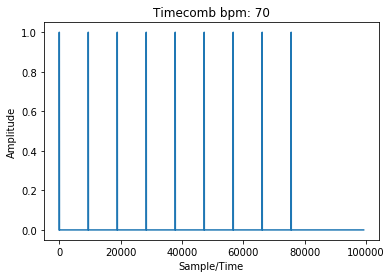

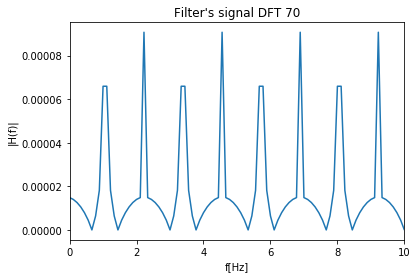

8.333333333333334


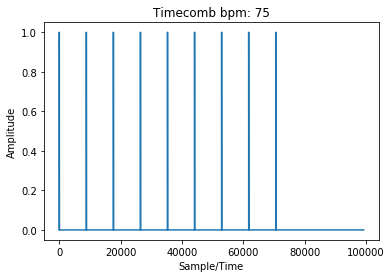

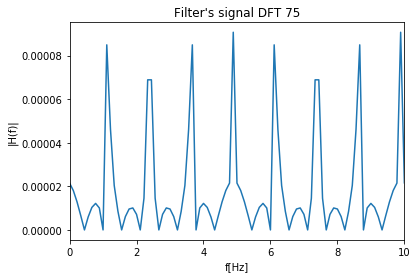

11.11111111111111


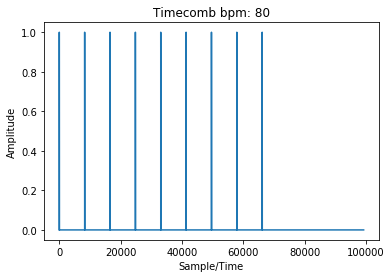

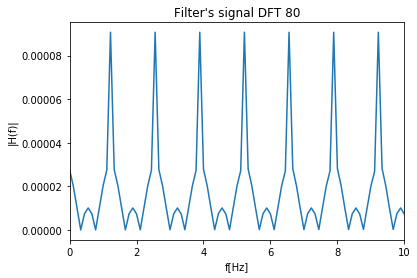

13.88888888888889


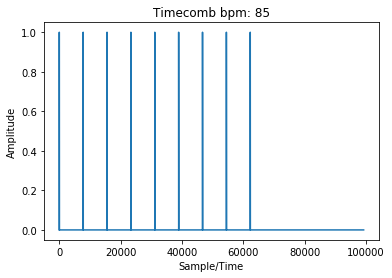

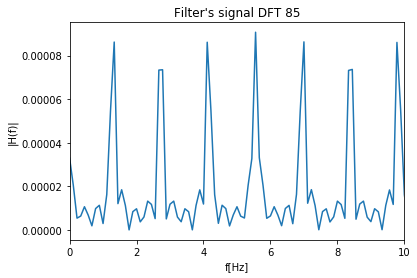

16.666666666666668


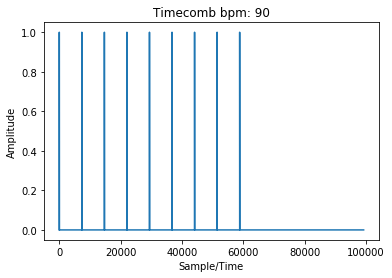

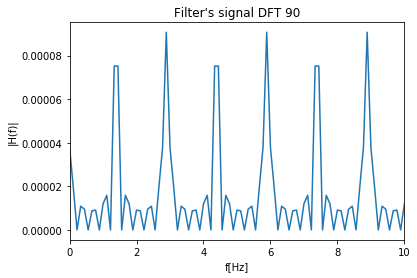

19.444444444444443


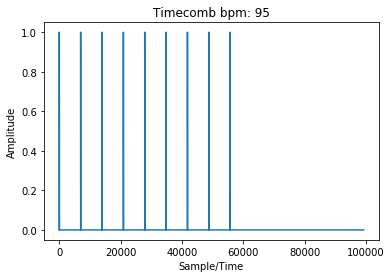

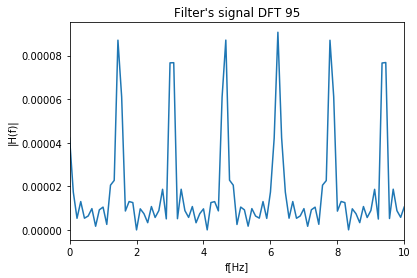

22.22222222222222


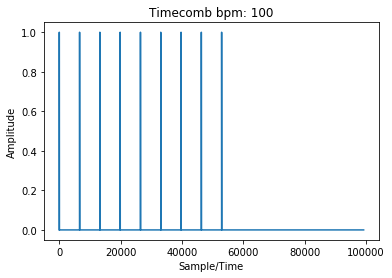

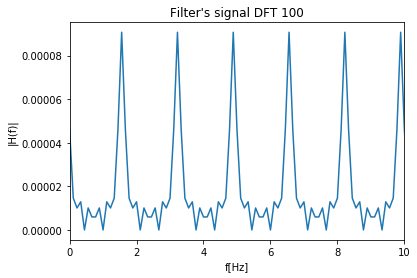

25.0


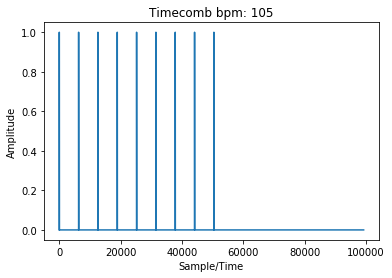

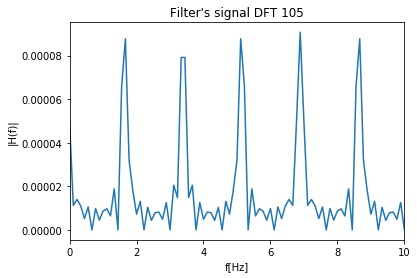

27.77777777777778


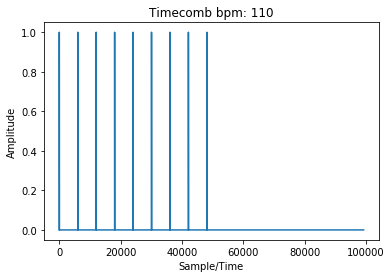

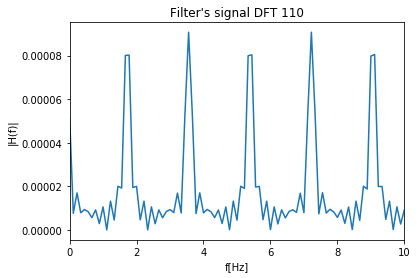

30.555555555555557


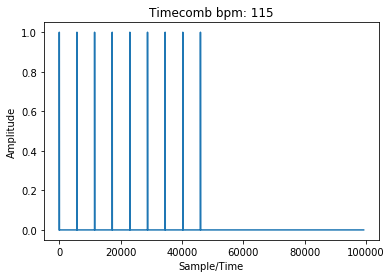

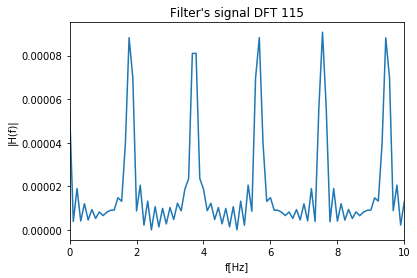

33.333333333333336


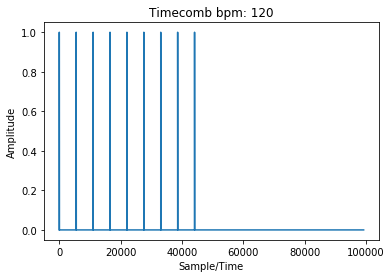

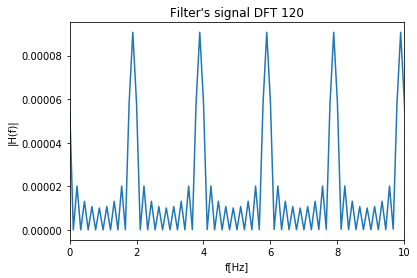

36.111111111111114


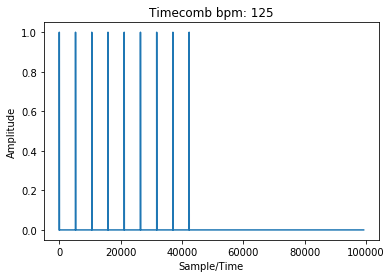

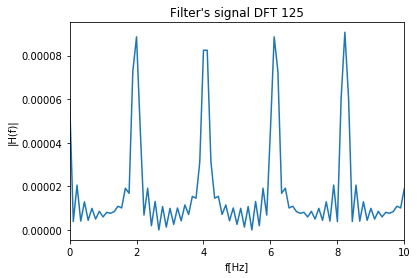

38.888888888888886


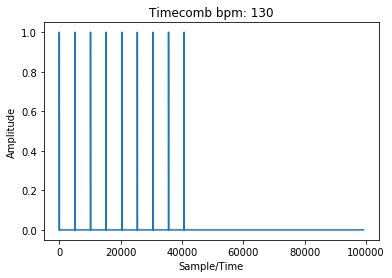

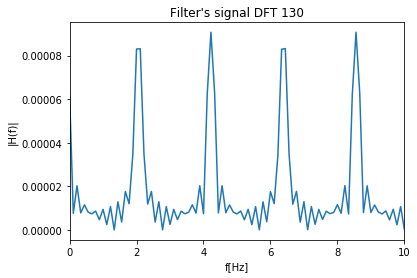

41.666666666666664


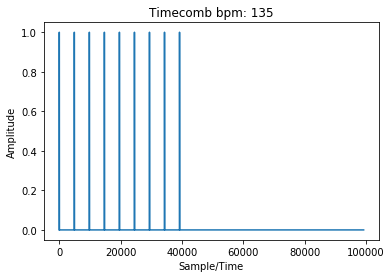

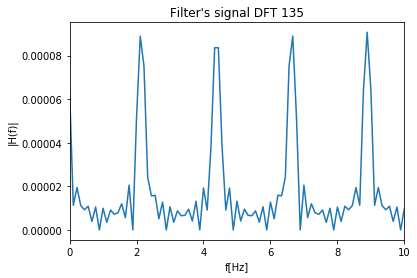

44.44444444444444


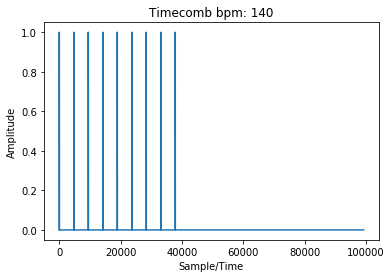

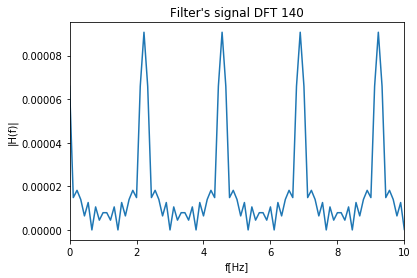

47.22222222222222


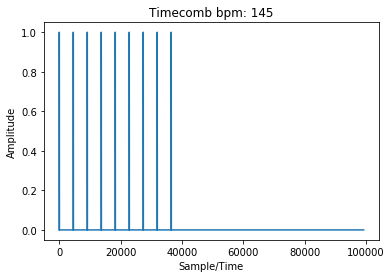

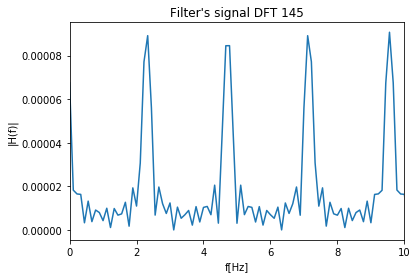

50.0


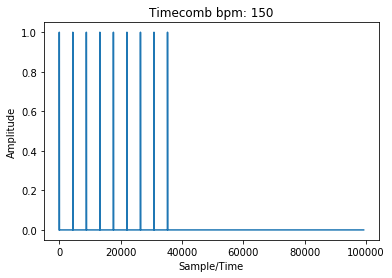

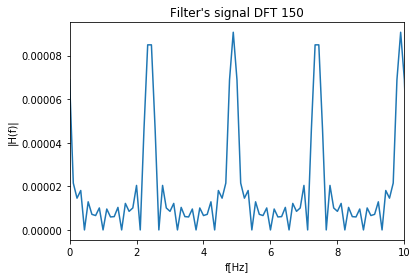

52.77777777777778


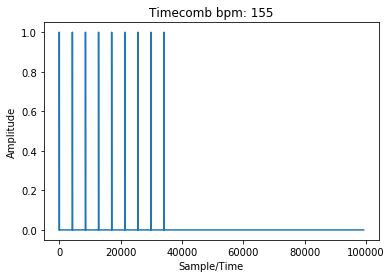

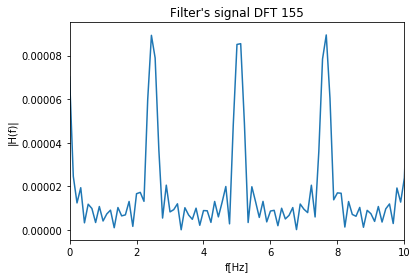

55.55555555555556


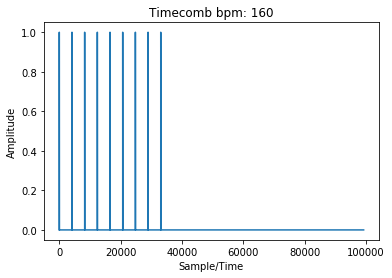

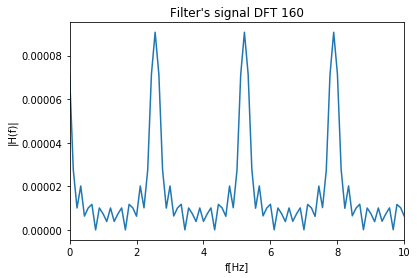

58.333333333333336


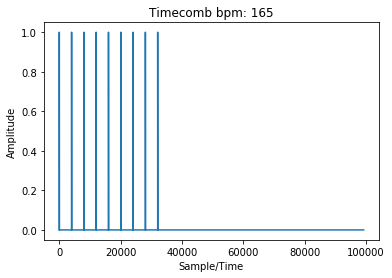

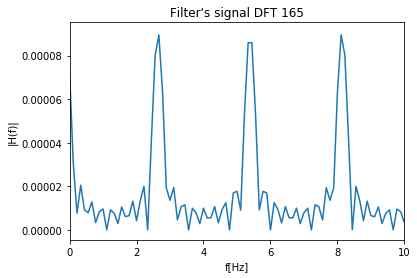

61.111111111111114


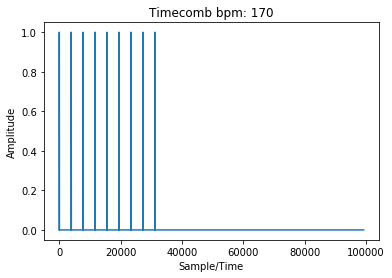

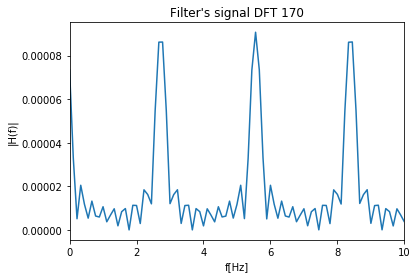

63.888888888888886


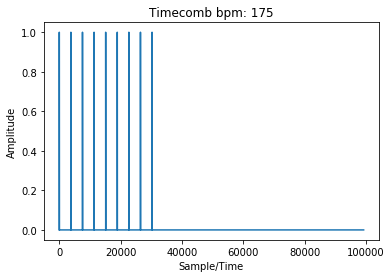

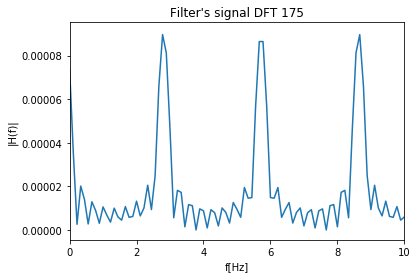

66.66666666666667


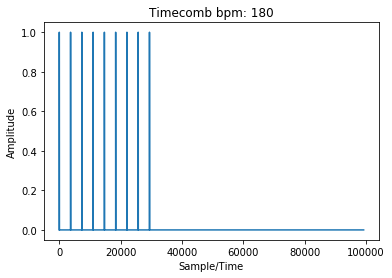

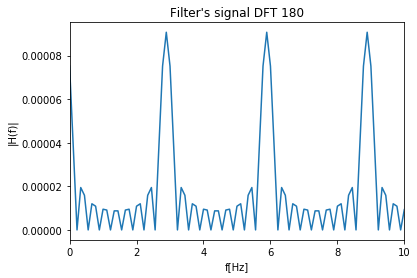

69.44444444444444


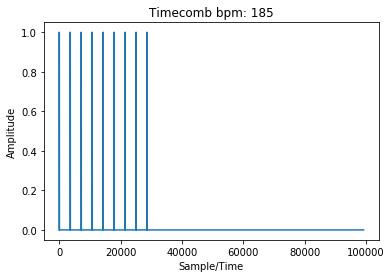

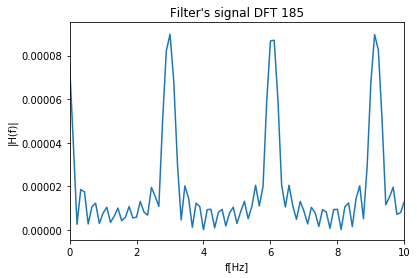

72.22222222222223


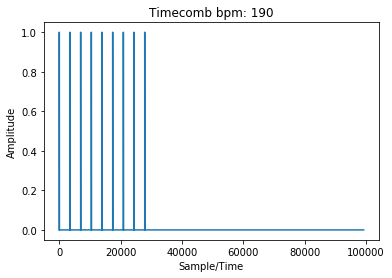

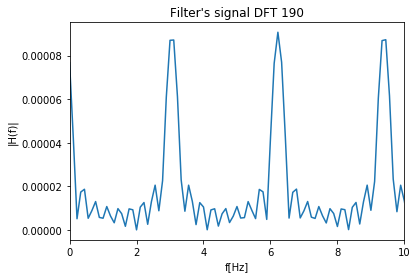

75.0


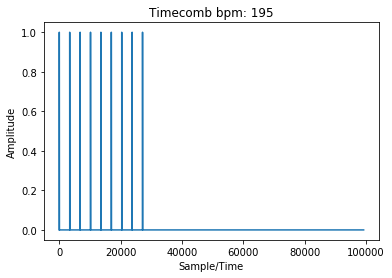

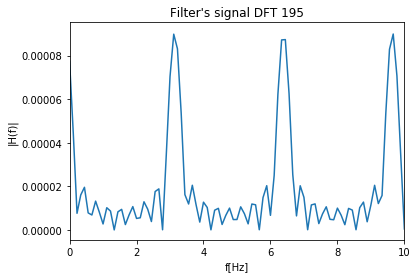

77.77777777777777


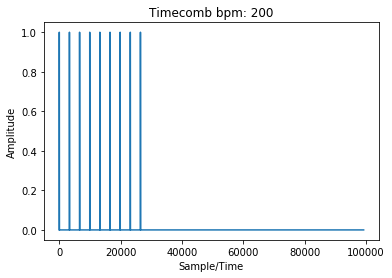

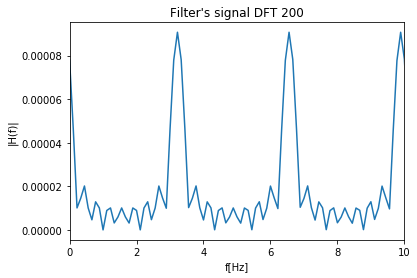

80.55555555555556


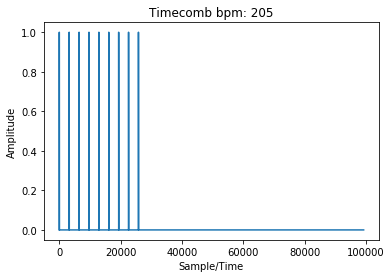

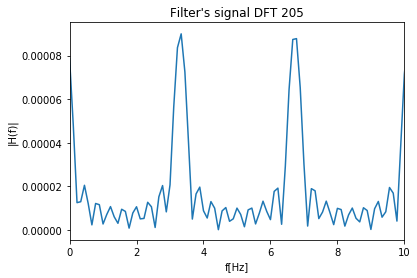

83.33333333333333


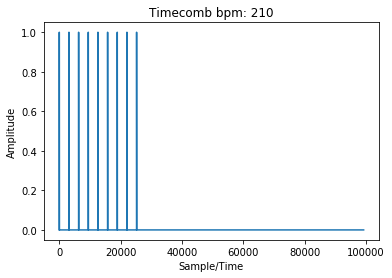

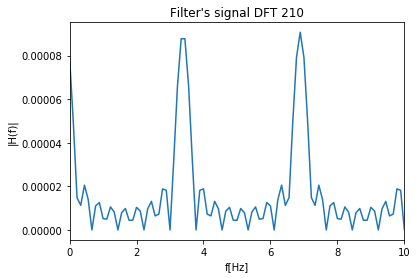

86.11111111111111


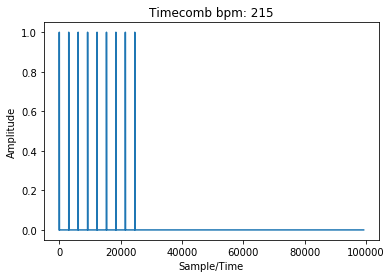

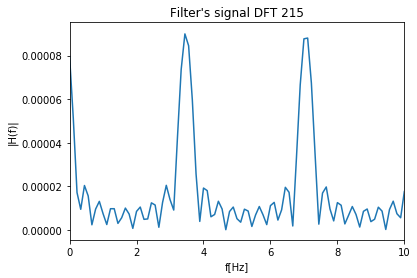

88.88888888888889


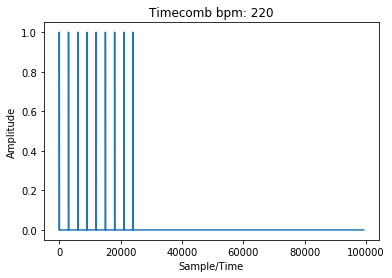

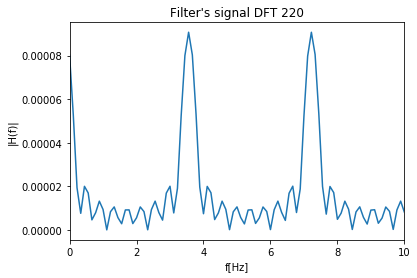

91.66666666666667


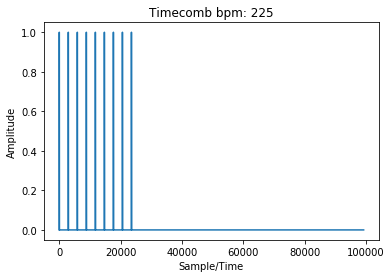

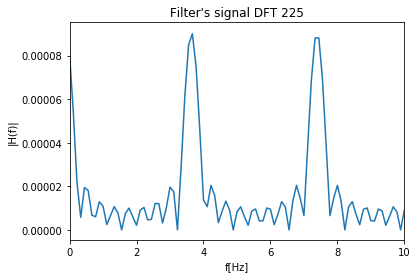

94.44444444444444


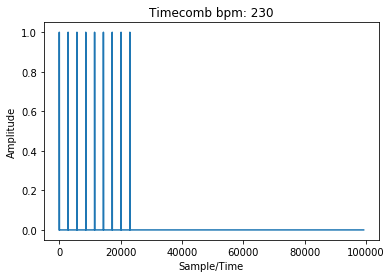

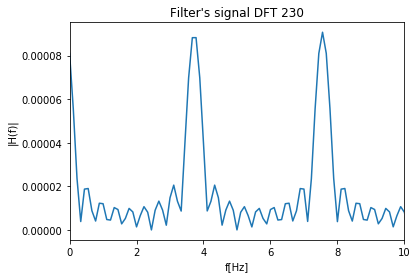

97.22222222222223


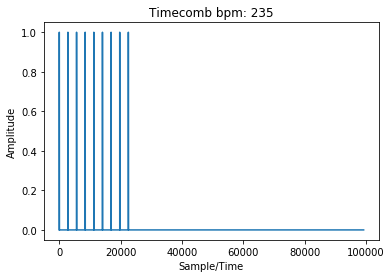

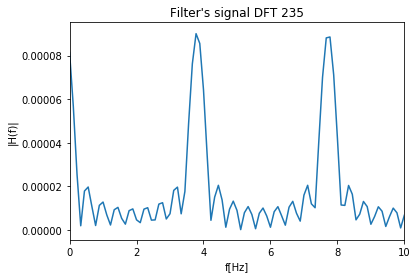

80

In [22]:
print(f'CombFiltering song {song.name}...')
plotDictionary = prepare_plot_dictionary(minBpm, maxBpm)
if useConvolveMethod: 
    first = bpm_comb_filter_convolve(diffrected,
                              5,
                              minBpm,
                              maxBpm,
                              bandLimits,
                              samplingFrequency,
                              plotDictionary)
else:
        first = bpm_comb_filter(diffrected,
                              5,
                              minBpm,
                              maxBpm,
                              bandLimits,
                              samplingFrequency,
                              combFilterPulses,
                              plotDictionary)
first

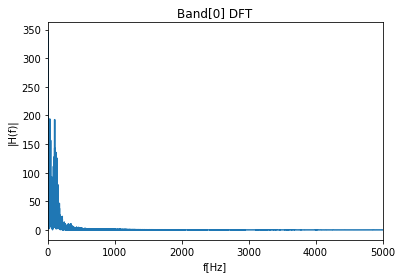

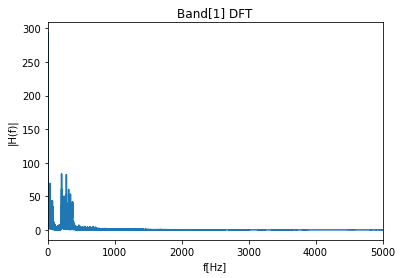

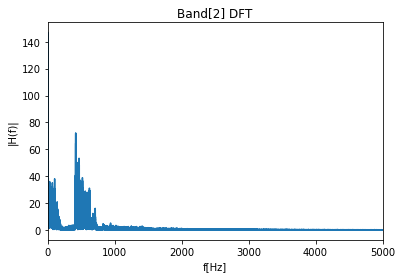

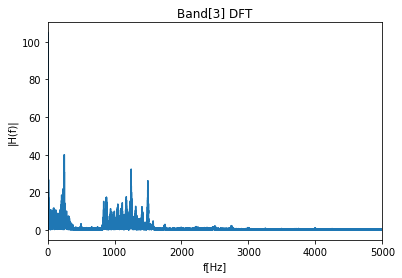

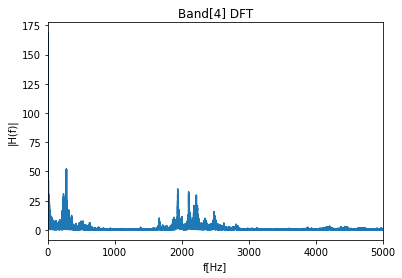

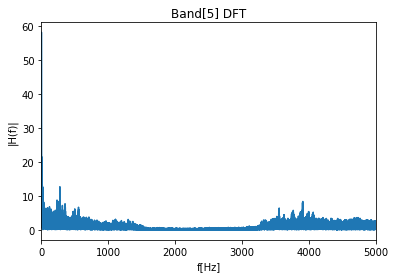

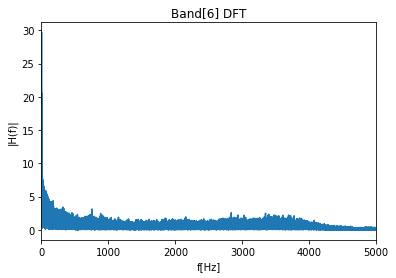

0.0


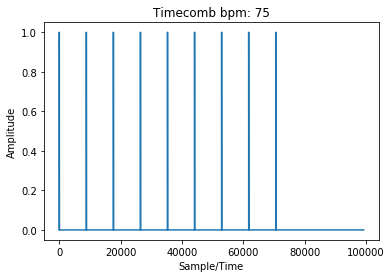

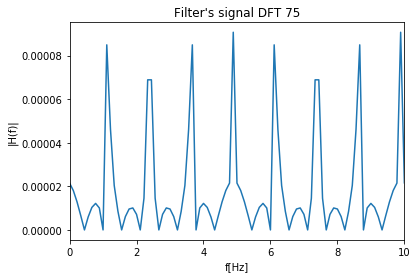

10.0


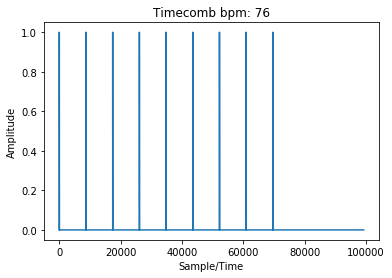

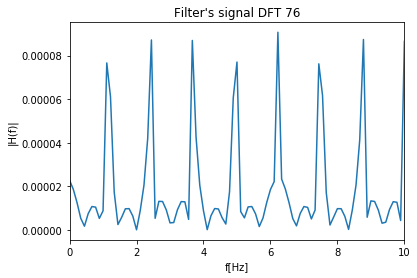

20.0


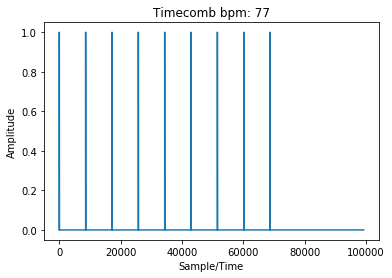

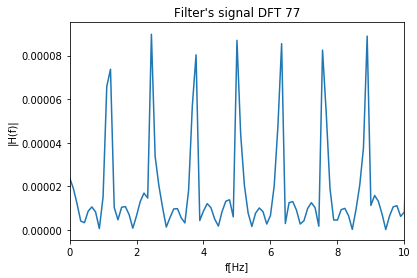

30.0


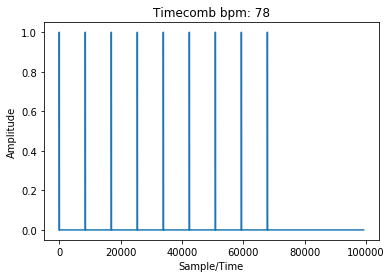

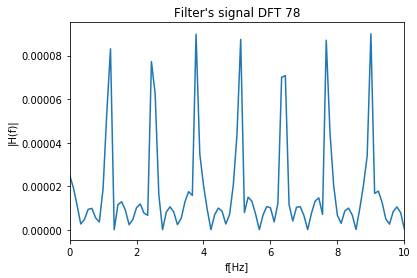

40.0


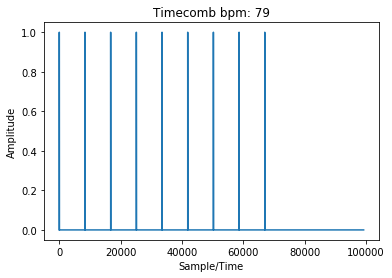

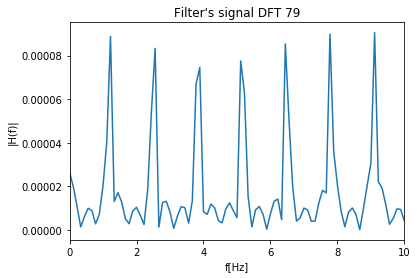

50.0


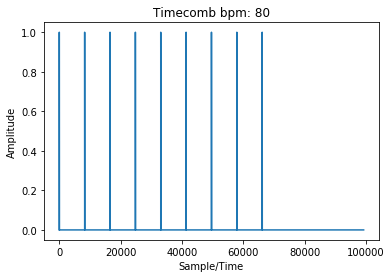

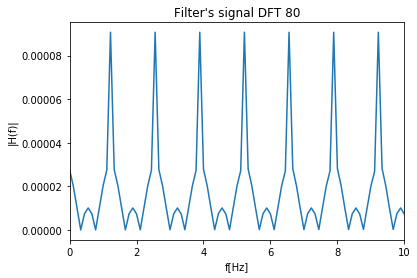

60.0


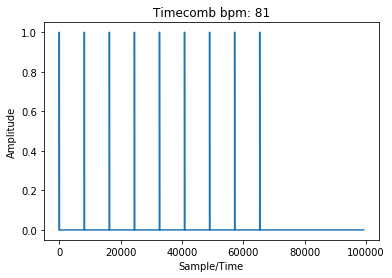

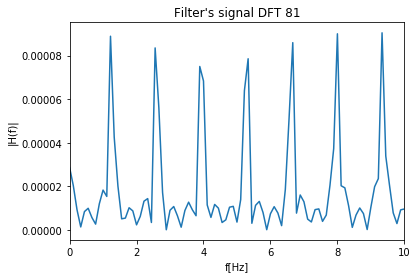

70.0


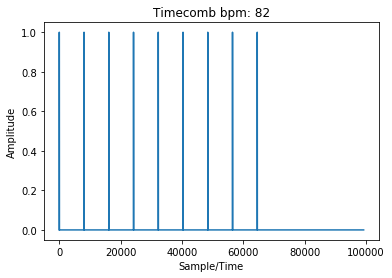

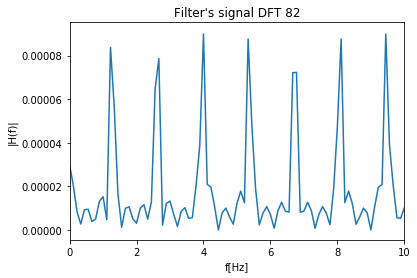

80.0


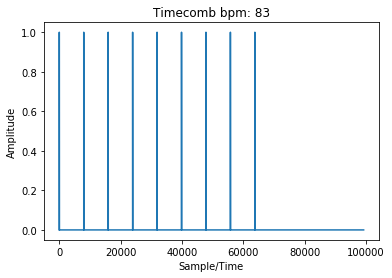

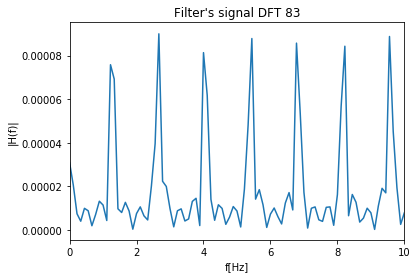

90.0


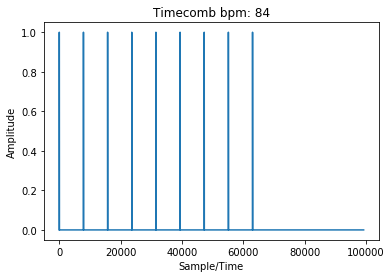

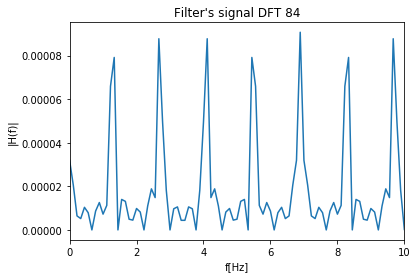

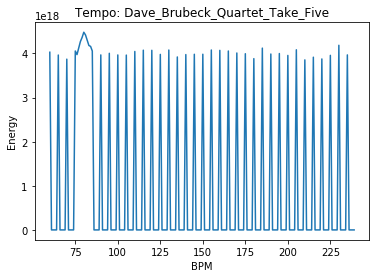

80

In [23]:
if useConvolveMethod:
    song_bpm = bpm_comb_filter_convolve(diffrected, 1, first - 5, first + 5, bandLimits, samplingFrequency, plotDictionary)
else:
    song_bpm = bpm_comb_filter(diffrected, 1, first - 5, first + 5, bandLimits, samplingFrequency, combFilterPulses, plotDictionary)
draw_plot(drawSongBpmEnergyPlot, list(plotDictionary.keys()), f"Tempo: {song.name}", "BPM", "Energy", list(plotDictionary.values()))
song_bpm

99225
74418


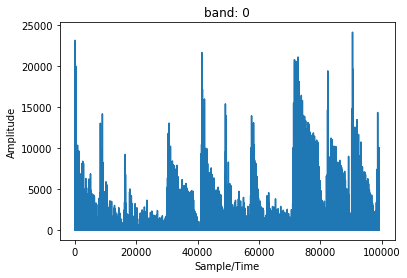

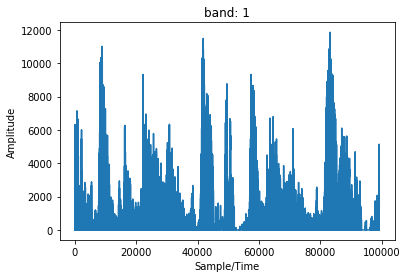

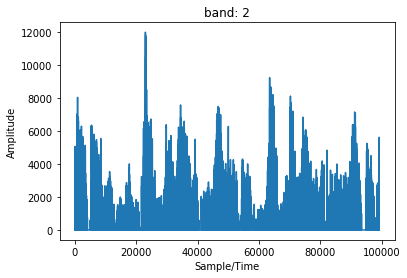

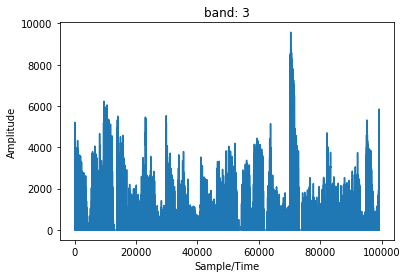

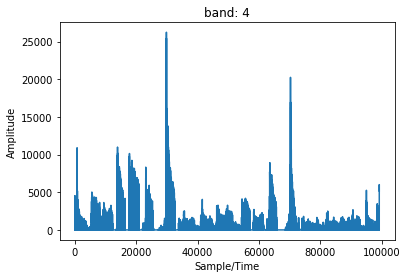

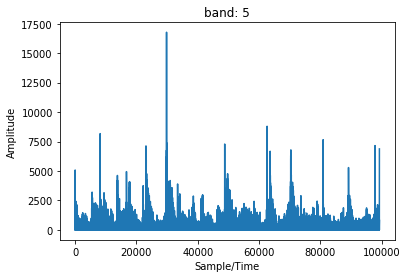

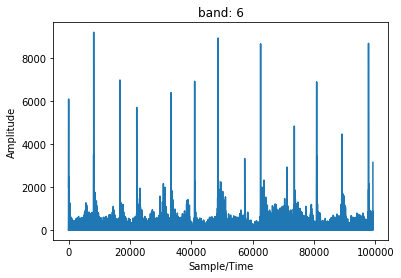

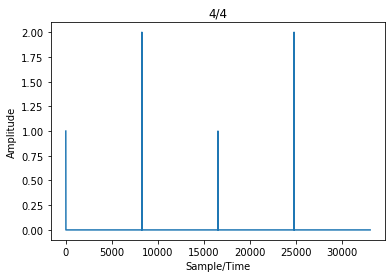

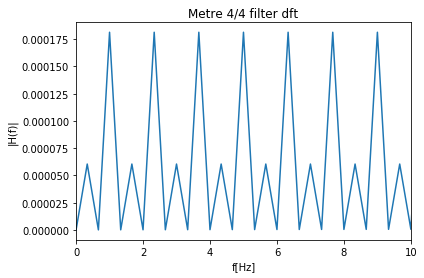

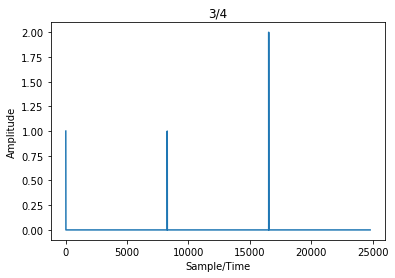

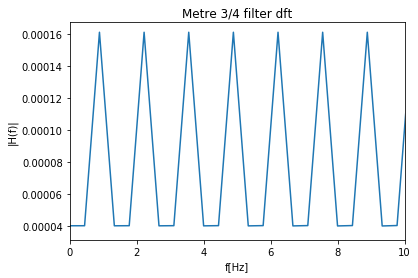

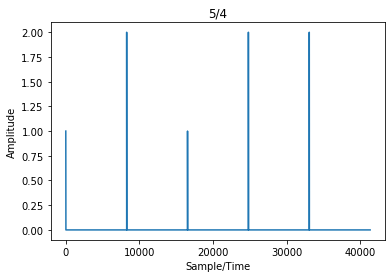

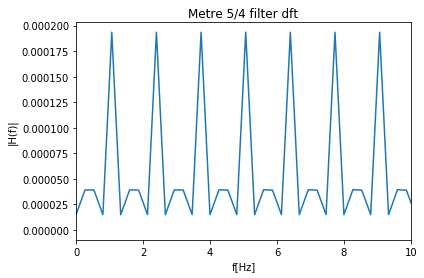

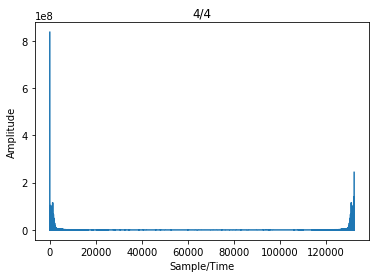

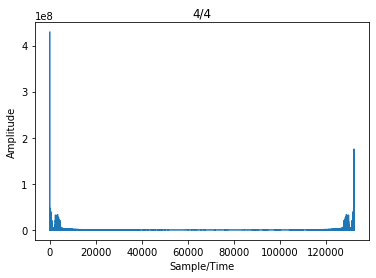

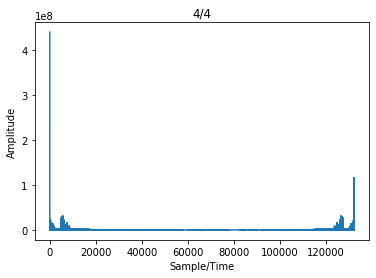

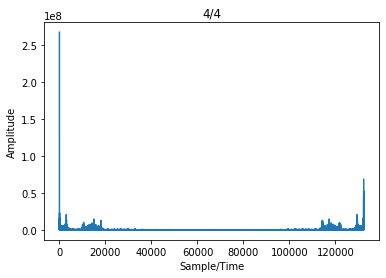

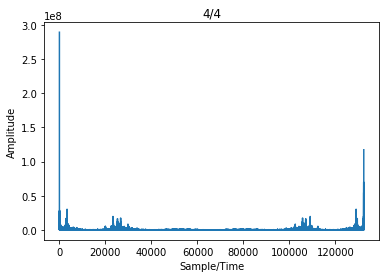

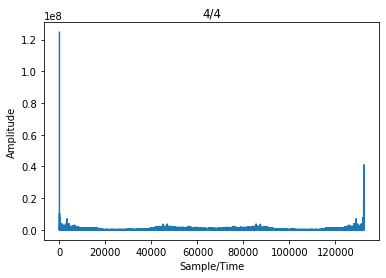

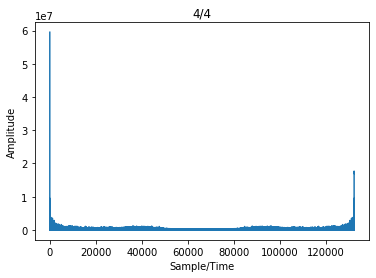

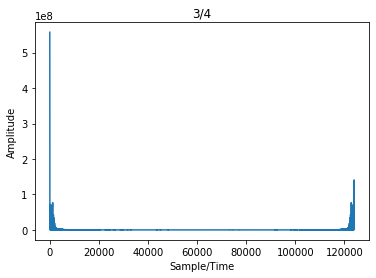

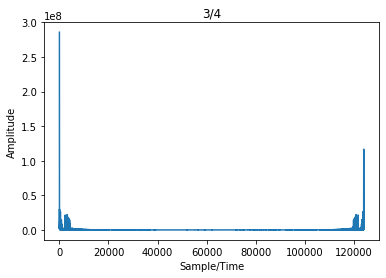

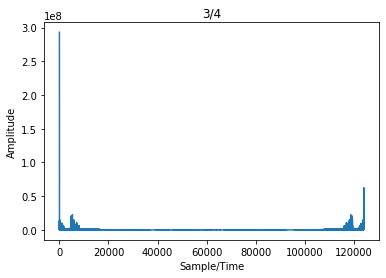

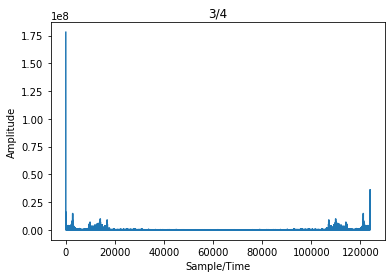

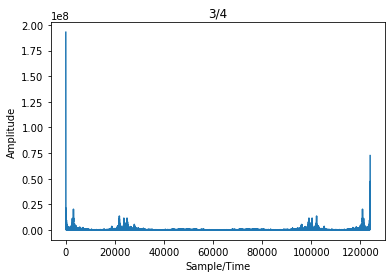

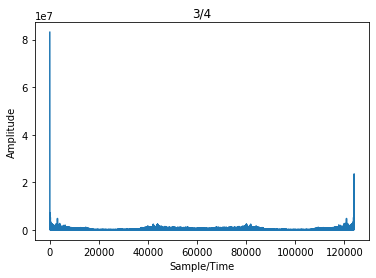

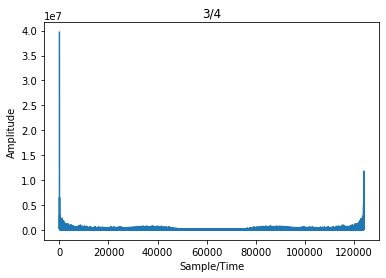

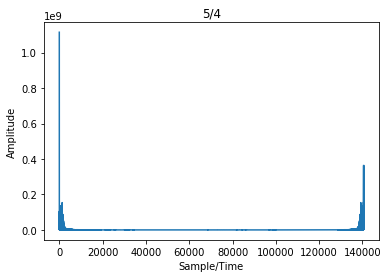

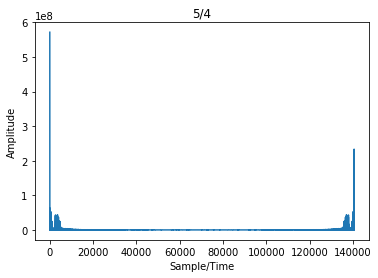

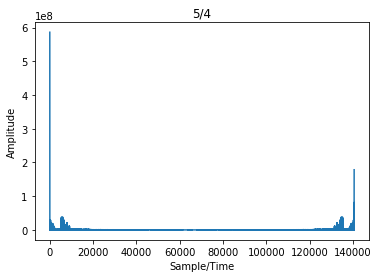

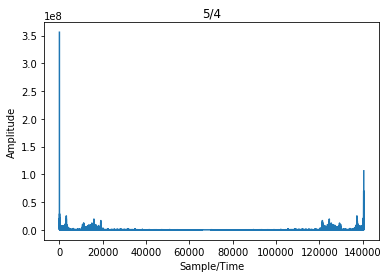

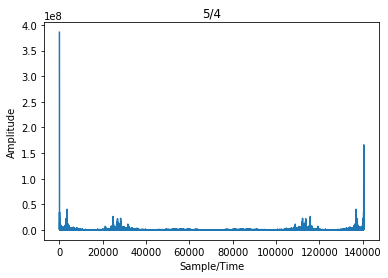

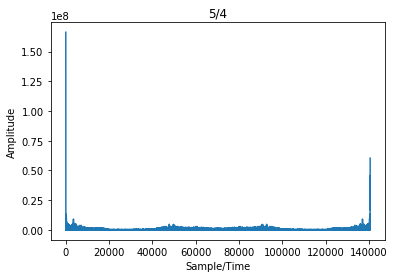

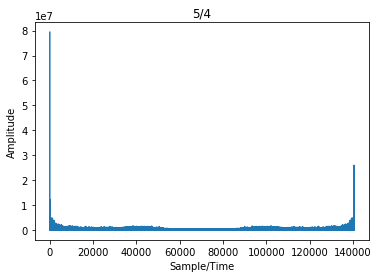

'5/4'

In [24]:
metre = detectMetre_convolve(diffrected, song_bpm, bandLimits, samplingFrequency, combFilterPulses)
metre

In [25]:
time = time.time() - startTime
time

92.1372275352478

In [26]:
!jupyter nbconvert --to script TempoMetreDetector.ipynb

[NbConvertApp] Converting notebook TempoMetreDetector.ipynb to script
[NbConvertApp] Writing 18985 bytes to TempoMetreDetector.py
